# Load Required Libraries

In [60]:
import pandas as pd
import requests
import io
from statsmodels.tsa.api import ExponentialSmoothing
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Load Data

In [61]:
# Load the data from Data Repository by Johns Hopkins CSSE
data = requests.get('https://raw.githubusercontent.com/ajain10003/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv').content
df = pd.read_csv(io.StringIO(data.decode('utf-8')))
df.head()

# gdp growth data
gdp_rate= pd.read_csv('gdp_data.csv', skiprows=4)

# pandemic data
pandemic_data= pd.read_csv('pandemic.csv',encoding='ISO-8859-1')

# Load Coronavirus Deaths data
data_death = requests.get('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv').content
df_death = pd.read_csv(io.StringIO(data.decode('utf-8')))

# Data Wrangling Steps

In [63]:
# Drop Null columns and not required columns from the DataFrame
corona_data = df.drop(['Province/State','Lat','Long'], axis=1)
corona_cases = pd.DataFrame(corona_data.sum(axis=0))
corona_cases.columns = ['case']
corona_cases = corona_cases.iloc[1:]
corona_cases.tail(1)

,case
4/26/20,2971475


# Forecasting

In [64]:
# Forecast Number of cases based on input days
case_input = corona_cases.values.ravel()
fit = ExponentialSmoothing(case_input).fit()
fit_add = ExponentialSmoothing(case_input, seasonal_periods=None, trend='add', seasonal=None).fit(use_boxcox=True)

# Plot chart

In [65]:
# Plot forecasted Cases
def plot_forecasted_cases(n):
    all_cases = case_input.tolist()
    forecasts= (fit_add.forecast(n))
    for i in range(len(forecasts)):
        all_cases.append(forecasts[i])
        
    # Plotting the cases
    plt.plot(all_cases)
    plt.title("Expected number of Total Cases")
    plt.show()

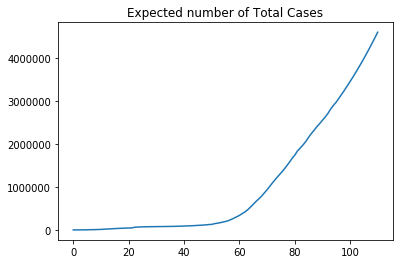

In [66]:
# Total Case prediction after 15 days
plot_forecasted_cases(15)

# Predict Impact on GDP

In [67]:
# Based on GDP data
world_gdp_rate= gdp_rate.loc[gdp_rate['Country Name'] == 'World']
world_gdp_rate.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], inplace=True)
gdp = world_gdp_rate.T
gdp.columns = ['GDP_growth']
gdp.fillna(0)
gdp_values= gdp.values
gdp_years= gdp.index

In [68]:
# subsetting pandemic data after 1960 
pandemic_data_in = pandemic_data.iloc[13:]

In [69]:
pandemic_data_final = pandemic_data_in.drop(columns=['Type / Pre-human host', 'Name'])

In [70]:
corona_death = df_death.drop(['Province/State', 'Lat','Long'], axis=1)
global_deaths= pd.DataFrame(corona_death.sum(axis=0))
total_death = global_deaths.tail(1)

In [71]:
total_death = total_death.values[0][0]

In [72]:
# creating dic of deaths from pandemic table
dict_death= {'1968':300000, '1967':300000,'1970':300000, '2009':100000,'2010':100000, '2002':770,'2014':5500,'2015':5500, '2020':total_death}

In [73]:
 ## pre processing GDP data
gdp['deaths']=0
gdp['year']=gdp.index
row=pd.DataFrame({'GDP_growth' :[0], 'deaths':[0], 'year':['2020']}, index=['2020'])
gdp=gdp.append(row)
gdp['deaths'] = gdp['year'].map(dict_death)
gdp.fillna(0, inplace=True)
gdp= gdp[gdp.year != 'Unnamed: 64']
gdp.at['2019','GDP_growth']= 2.6

In [74]:
gdp

,GDP_growth,deaths,year
1960,0.000000,0.0,1960
1961,4.300374,0.0,1961
1962,5.554036,0.0,1962
1963,5.353451,0.0,1963
1964,6.714764,0.0,1964
...,...,...,...
2016,2.481500,0.0,2016
2017,3.108815,0.0,2017
2018,2.973651,0.0,2018
2019,2.600000,0.0,2019


# Plot deaths and GPD rate

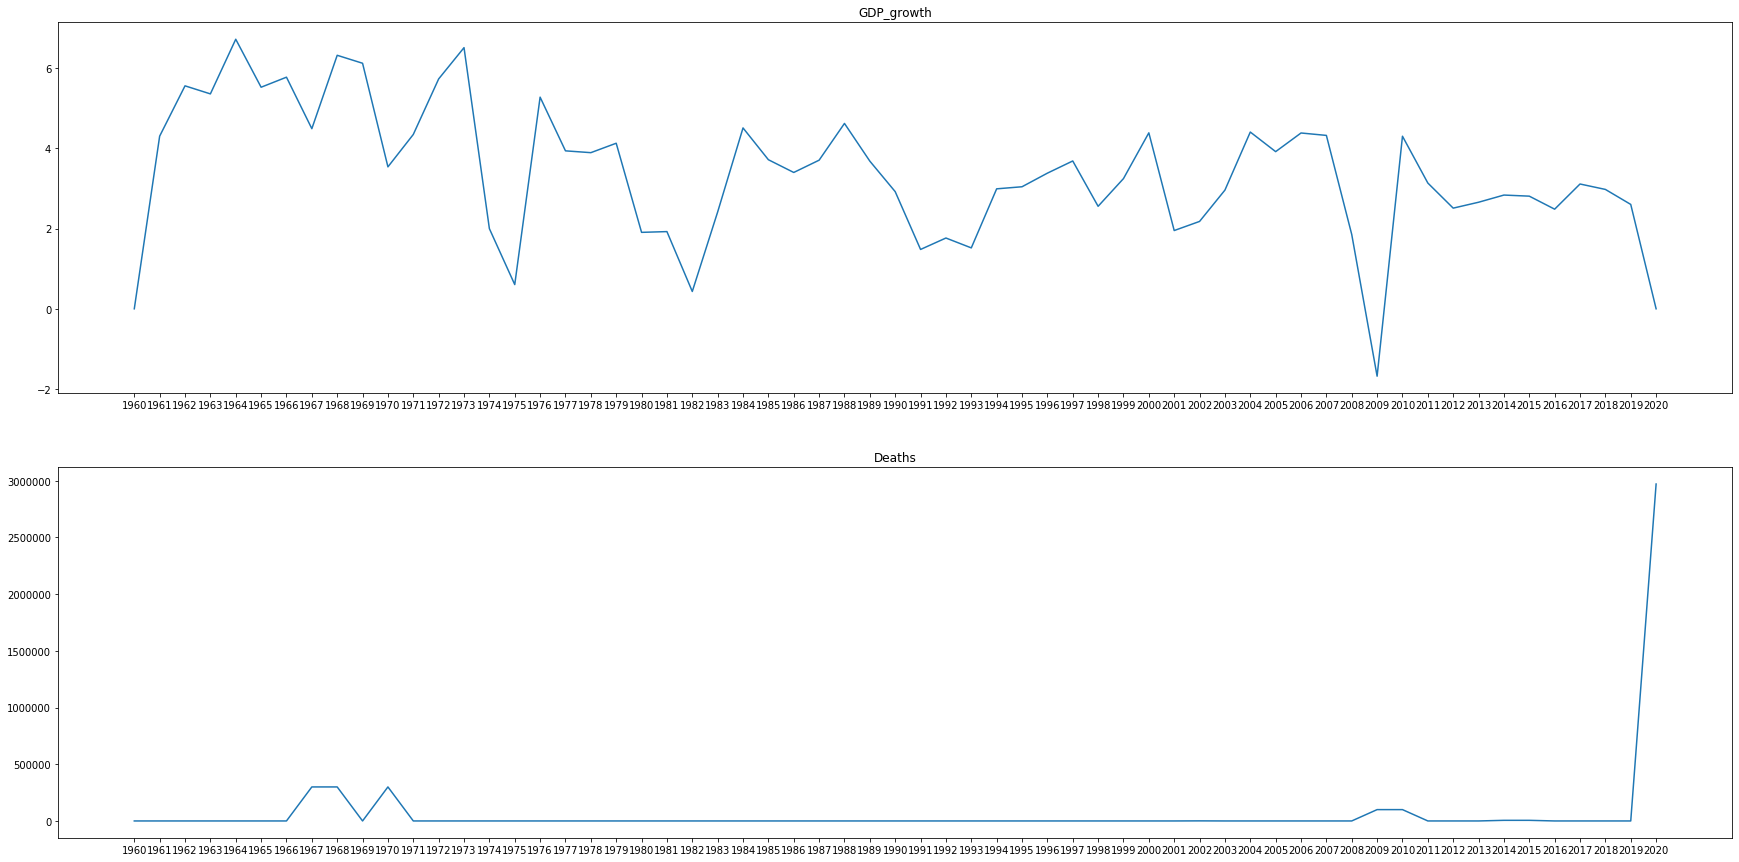

In [80]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(30)
year = gdp.year
growth = gdp.GDP_growth
deaths = gdp.deaths

ax1 = plt.subplot(211)
plt.plot(year, growth)
plt.title("GDP_growth")
plt.setp(ax1.get_xticklabels(), fontsize=10)

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(year, deaths)
plt.title("Deaths")
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=True)

plt.show()